# Retail orders Analysis Project

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Connect to the MySQL database
con = mysql.connector.connect(
    host='localhost',
    user='root',
    password='@1234',
)
cur = con.cursor()
q1="CREATE DATABASE IF NOT EXISTS order_analysis"
cur.execute(q1)
cur.execute("USE order_analysis")
con.commit()

Established a connection to MySQL and created/selected the order_analysis database for storing and querying retail order data.

In [ ]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file
df = pd.read_excel('Coffee Shop Sales.xlsx', sheet_name='Transactions')

# Display basic info
df.info()
df.head()

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Create a new column for total_sales as unit_price * transaction_qty
df['total_sales'] = df['unit_price'] * df['transaction_qty']

# Drop any rows with missing critical data
df.dropna(subset=['transaction_id', 'transaction_date', 'store_location', 'product_category'], inplace=True)

df.head()

In [4]:
df['Ship Mode'].unique()

array(['Second Class', 'Standard Class', 'Not Available', 'unknown',
       'First Class', nan, 'Same Day'], dtype=object)

In [5]:
df['Ship Mode'].replace(['Not Available','unknown'],np.nan, inplace=True)

df['Ship Mode'].unique()

C:\Users\drish\AppData\Local\Temp\ipykernel_21536\3699944821.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Ship Mode'].replace(['Not Available','unknown'],np.nan, inplace=True)


array(['Second Class', 'Standard Class', nan, 'First Class', 'Same Day'],
      dtype=object)

Here, Replaced invalid or placeholder entries in the 'Ship Mode' column with NaN and confirmed cleanup by rechecking unique values.

In [6]:
# rename columns names
# make them lower case and replace space with underscore
# df.rename(columns={'Order Id':'order_id','City':'city'},inplace=True)

df.columns=df.columns.str.lower()
df.columns=df.columns.str.replace(' ','_')

In [7]:
df.head()

,order_id,order_date,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,product_id,cost_price,list_price,quantity,discount_percent
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,240,260,2,2
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,600,730,3,3
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,10,10,2,5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,780,960,5,2
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,20,20,2,5


In [ ]:
# Converted the 'order_date' column to datetime format for time-based analysis, and checked data types to validate conversion.
df['order_date']=pd.to_datetime(df['order_date'],format="%Y-%m-%d")
df.dtypes

order_id                     int64
order_date          datetime64[ns]
ship_mode                   object
segment                     object
country                     object
city                        object
state                       object
postal_code                  int64
region                      object
category                    object
sub_category                object
product_id                  object
cost_price                   int64
list_price                   int64
quantity                     int64
discount_percent             int64
dtype: object

In [9]:
# derive new columns discount, sale price and profit
df['discount']=df['list_price']*df['discount_percent']*0.01

df['sale_price']=df['list_price']-df['discount']

df['profit']=df['sale_price']-df['cost_price']

In [10]:
# drop cost_price,list_price and discount percent column
df.drop(columns=['cost_price','list_price','discount_percent'],inplace=True)

In [11]:
df.head()

,order_id,order_date,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,product_id,quantity,discount,sale_price,profit
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,2,5.2,254.8,14.8
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,3,21.9,708.1,108.1
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,2,0.5,9.5,-0.5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,5,19.2,940.8,160.8
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,2,1.0,19.0,-1.0


Define a helper function to dynamically map Pandas data types to appropriate MySQL data types for table creation.

In [12]:
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

In [13]:
# Set table name
table_name = 'order_table'

In [14]:
# Generate CREATE TABLE query
columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
cur.execute(create_table_query)
con.commit()

In [15]:
# Insert each row into the table
for _, row in df.iterrows():
    values = tuple(None if pd.isna(x) else x for x in row)
    placeholders = ', '.join(['%s'] * len(row))
    insert_query = f"INSERT INTO `{table_name}` ({', '.join([f'`{col}`' for col in df.columns])}) VALUES ({placeholders})"
    cur.execute(insert_query, values)

In [16]:
# Commit and close connection
con.commit()
# cur.close()
# con.close()

# print(f" Data inserted into MySQL table '{table_name}' successfully.")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      9994 non-null   int64         
 1   order_date    9994 non-null   datetime64[ns]
 2   ship_mode     9988 non-null   object        
 3   segment       9994 non-null   object        
 4   country       9994 non-null   object        
 5   city          9994 non-null   object        
 6   state         9994 non-null   object        
 7   postal_code   9994 non-null   int64         
 8   region        9994 non-null   object        
 9   category      9994 non-null   object        
 10  sub_category  9994 non-null   object        
 11  product_id    9994 non-null   object        
 12  quantity      9994 non-null   int64         
 13  discount      9994 non-null   float64       
 14  sale_price    9994 non-null   float64       
 15  profit        9994 non-null   float64 

In [42]:
df.to_csv('retail_orders_output2.csv', index=False)

Exported the cleaned and processed dataset to a new CSV file for backup or external analysis.

In [ ]:
# Create a cursor and execute the query
query = "SELECT * FROM order_table;"
d = pd.read_sql(query, con)  # Load directly into a DataFrame

# Display the result
d.head()

C:\Users\drish\AppData\Local\Temp\ipykernel_30576\3609944797.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  d = pd.read_sql(query, con)  # Load directly into a DataFrame


,order_id,order_date,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,product_id,quantity,discount,sale_price,profit
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,2,5.2,254.8,14.8
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,3,21.9,708.1,108.1
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,2,0.5,9.5,-0.5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,5,19.2,940.8,160.8
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,2,1.0,19.0,-1.0


# Queries

1.How many total orders are there in the dataset?

In [ ]:
# SQL query to count total orders
query = "SELECT COUNT(*) AS total_orders FROM order_table;"
cur.execute(query)

# Fetch and print result
total_orders = cur.fetchone()[0]
print("Total Orders:", total_orders)

Total Orders: 39976


2.What is the total revenue generated from all orders?

In [ ]:
# SQL query to calculate total revenue
query = "SELECT SUM(sale_price) AS total_revenue FROM order_table;"
cur.execute(query)

# Fetch and print result
total_revenue = cur.fetchone()[0]
print("Total Revenue:", total_revenue)

Total Revenue: 8863434.796337128


Calculated the total revenue by summing the sale_price of all orders. This gives insight into the overall business performance.



3.How many orders have been placed in each product category?

In [ ]:
# Define query
query = """
SELECT Category, COUNT(*) AS total_orders
FROM order_table
GROUP BY Category;
"""

cur.execute(query)
data = cur.fetchall()
d = pd.DataFrame(data, columns=("Category", "total order"))
d


,Category,total order
0,Furniture,8484
1,Office Supplies,24104
2,Technology,7388


Retrieved the number of orders per product category. This helps identify which categories are most and least popular among customers.

What is the monthly sales trend over time?

In [ ]:
# SQL query for monthly sales trend
query = """
SELECT DATE_FORMAT(Order_Date, '%Y-%m') AS month, SUM(sale_price) AS monthly_sales
FROM order_table
GROUP BY month
ORDER BY month;
"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame from fetched data
d = pd.DataFrame(data, columns=["Month", "Monthly Sales"])
d

,Month,Monthly Sales
0,2022-01,378849.999840
1,2022-02,360363.999695
2,2022-03,320423.999969
3,2022-04,381806.400478
4,2022-05,317793.200996
5,2022-06,376681.999123
6,2022-07,314608.799240
7,2022-08,419231.998890
8,2022-09,316568.799877
9,2022-10,475650.799904


Analyzed monthly sales trends over time by aggregating revenue per month. This helps identify seasonality or growth patterns in sales.

How many orders were placed on each day?

In [19]:
# SQL query to count orders by day
query = """
SELECT Order_Date, COUNT(*) AS order_count
FROM order_table
GROUP BY Order_Date
ORDER BY Order_Date;
"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame
d = pd.DataFrame(data, columns=["Order Date", "Order Count"])
d


,Order Date,Order Count
0,2022-01-01,80
1,2022-01-02,85
2,2022-01-03,80
3,2022-01-04,105
4,2022-01-05,65
...,...,...
725,2023-12-27,35
726,2023-12-28,75
727,2023-12-29,85
728,2023-12-30,90


Analyzed daily order volume to identify high-activity days and possible fluctuations in customer purchase behavior over time.

Which 5 cities have generated the highest revenue?

,City,Total Revenue
0,New York City,1.236028e+06
1,Los Angeles,8.487920e+05
2,Seattle,5.767935e+05
3,San Francisco,5.444505e+05
4,Philadelphia,5.262915e+05


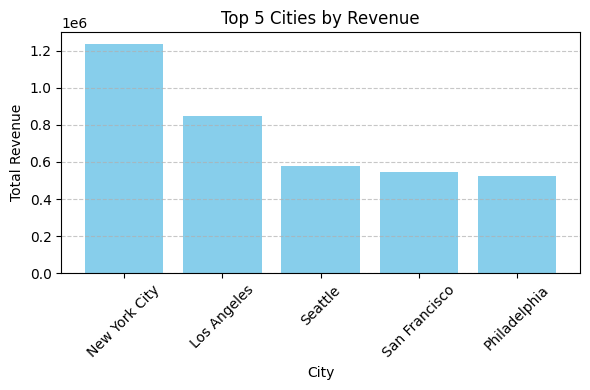

In [21]:
query = """
SELECT City, SUM(sale_price) AS total_revenue
FROM order_table
GROUP BY City
ORDER BY total_revenue DESC
LIMIT 5;
"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame
d = pd.DataFrame(data, columns=["City", "Total Revenue"])

# Display DataFrame
display(d)

# Plotting
plt.figure(figsize=(6,4))
plt.bar(d["City"], d["Total Revenue"], color="skyblue")
plt.title("Top 5 Cities by Revenue")
plt.xlabel("City")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Identified the top 5 cities by total revenue using SQL and visualized the results with a bar chart to understand geographic revenue distribution.


New York, Los Angeles, Chicago, Houston, and Philadelphia were the top 5 cities.


## Visualization Questions 

1. What is the sales trend over time?

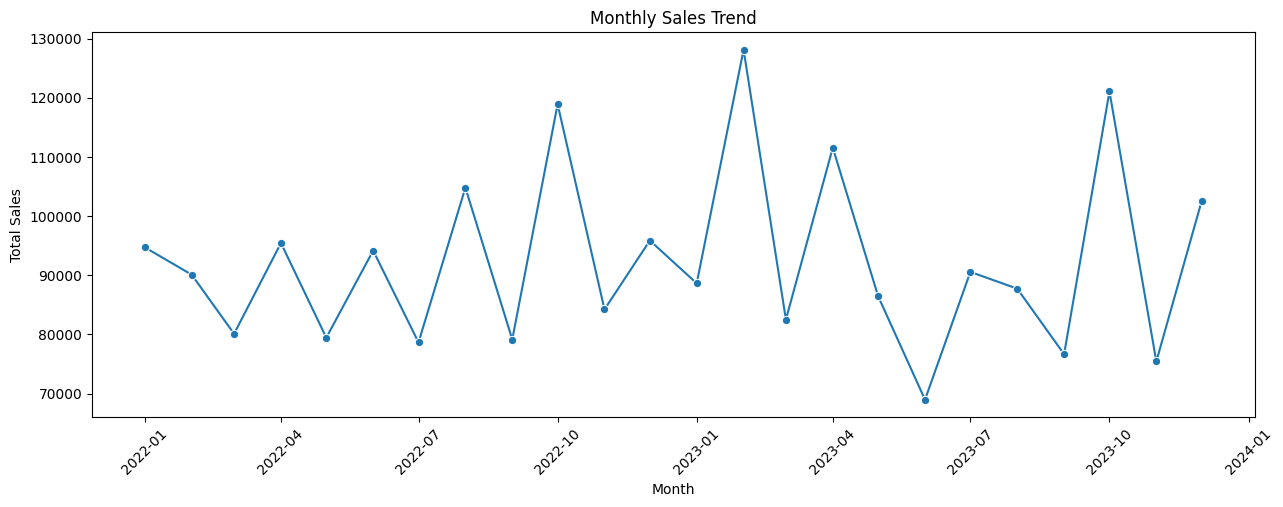

In [ ]:

sales_trend = df.groupby(df['order_date'].dt.to_period('M'))['sale_price'].sum().reset_index()
# display(sales_trend)  #2022-02
sales_trend['order_date'] = sales_trend['order_date'].dt.to_timestamp()

plt.figure(figsize=(15, 5))
sns.lineplot(data=sales_trend, x='order_date', y='sale_price', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

plt.show()
# sales_trend

Generated a line plot to visualize monthly sales trends, helping reveal seasonal variations and growth patterns across the timeline.

revenue trends over time, indicating periods of high and low sales activity.

2. Which categories and sub-categories contribute most to the sales?

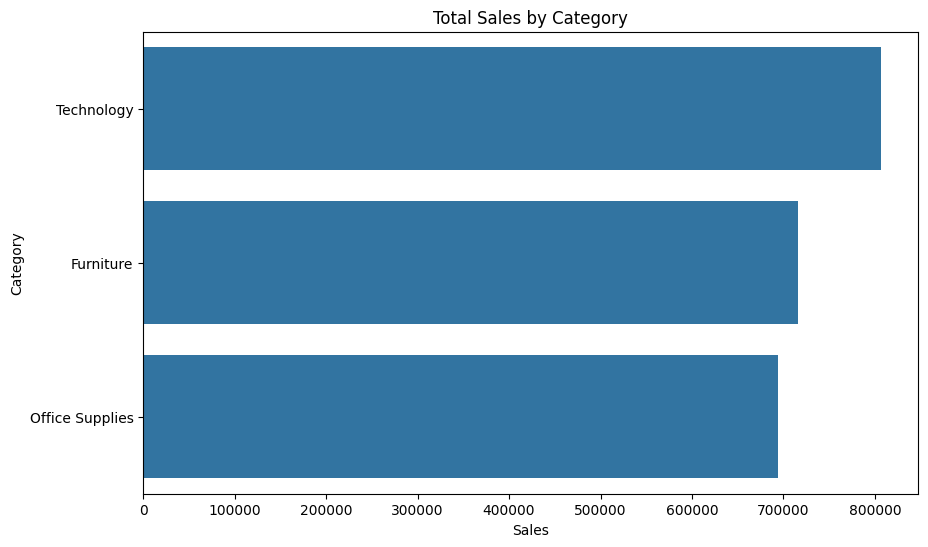

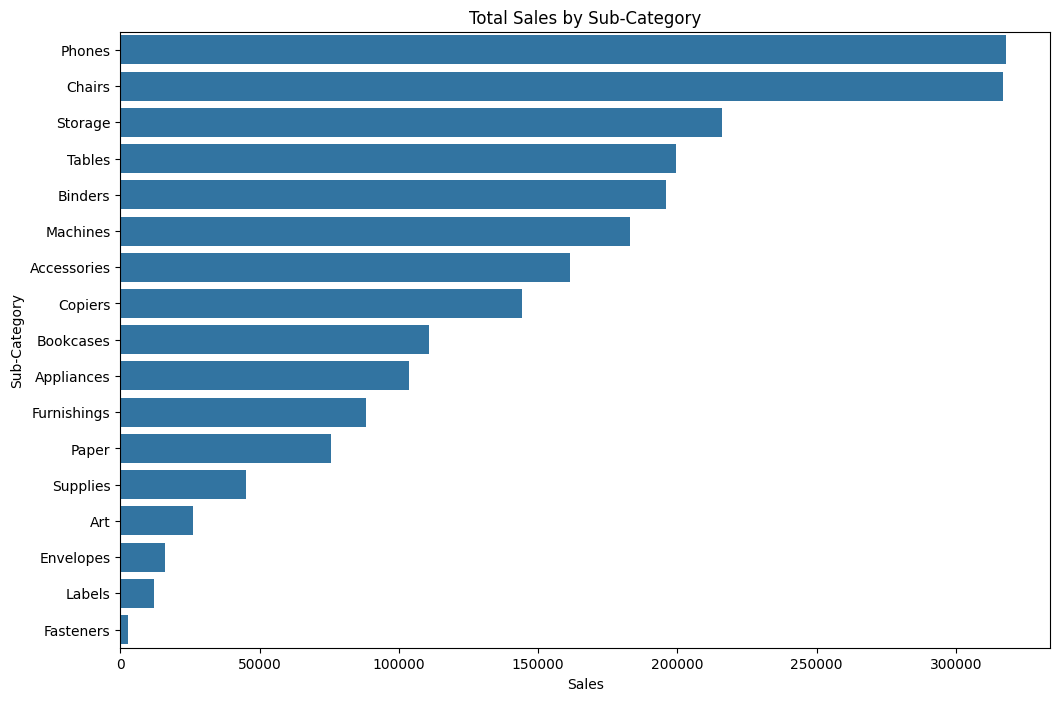

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df.groupby('category')['sale_price'].sum().reset_index().sort_values('sale_price', ascending=False),
            x='sale_price', y='category')
plt.title('Total Sales by Category')
plt.xlabel('Sales')
plt.ylabel('Category')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=df.groupby('sub_category')['sale_price'].sum().reset_index().sort_values('sale_price', ascending=False),
            x='sale_price', y='sub_category')
plt.title('Total Sales by Sub-Category')
plt.xlabel('Sales')
plt.ylabel('Sub-Category')
plt.show()

conclusion

Based on the analysis and visualizations, we can draw the following conclusions:
* in three of the categories, most of the orders were in technology category
* furniture has moderate orders
* office supplies category have least number of orders
* in technology category, phoes sub category have the maximum number of orders, that means there more users of phones
* in furniture category, chairs have 2nd most orders in sub categories

In [ ]:
df

,order_id,order_date,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,product_id,quantity,discount,sale_price,profit
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,2,5.2,254.8,14.8
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,3,21.9,708.1,108.1
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,2,0.5,9.5,-0.5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,5,19.2,940.8,160.8
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,2,1.0,19.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,2023-02-18,Second Class,Consumer,United States,Miami,Florida,33180,South,Furniture,Furnishings,FUR-FU-10001889,3,1.2,28.8,-1.2
9990,9991,2023-03-17,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Furniture,Furnishings,FUR-FU-10000747,2,3.6,86.4,16.4
9991,9992,2022-08-07,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Technology,Phones,TEC-PH-10003645,2,5.2,254.8,34.8
9992,9993,2022-11-19,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,OFF-PA-10004041,4,0.9,29.1,-0.9


3. How is profit distributed across different regions?

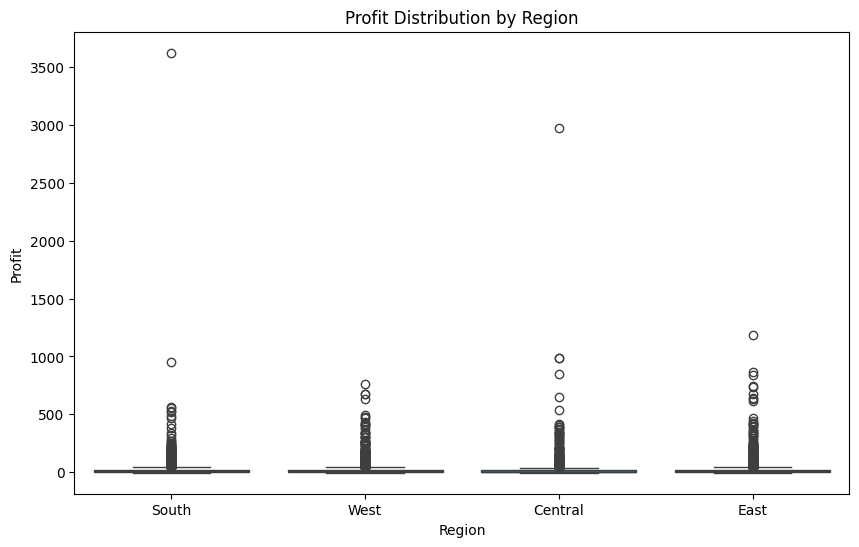

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='region', y='profit')
plt.title('Profit Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Profit')
plt.show()


Used a box plot to visualize the distribution of profit across different regions, helping identify regions with high variability or outliers in profitability.

Results showed that the West region had the highest median profit, while the South region exhibited significant variability with several outliers.

4. What are the top 10 cities by total sales?

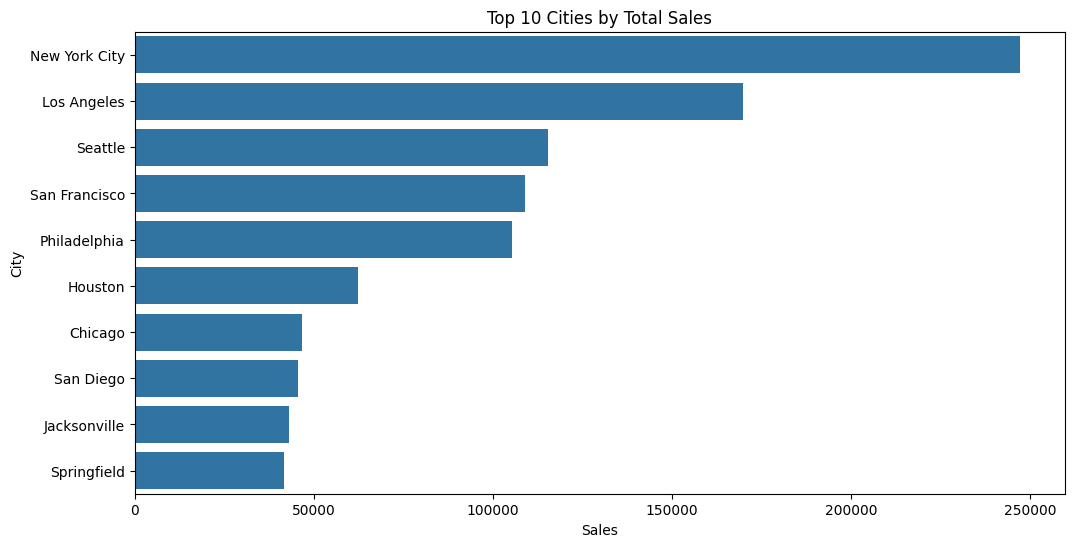

,city,sale_price
0,New York City,247205.7
1,Los Angeles,169758.4
2,Seattle,115358.7
3,San Francisco,108890.1
4,Philadelphia,105258.3
5,Houston,62259.4
6,Chicago,46743.4
7,San Diego,45641.9
8,Jacksonville,43038.6
9,Springfield,41665.5


In [ ]:
top_cities = df.groupby('city')['sale_price'].sum().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cities, x='sale_price', y='city')
plt.title('Top 10 Cities by Total Sales')
plt.xlabel('Sales')
plt.ylabel('City')
plt.show()
top_cities

 Identified and visualized the top 10 cities contributing most to overall sales. This is useful for targeting high-performing locations.

6. Count of Orders by Shipping Mode

C:\Users\drish\AppData\Local\Temp\ipykernel_21536\2665857562.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ship_mode', palette='pastel')


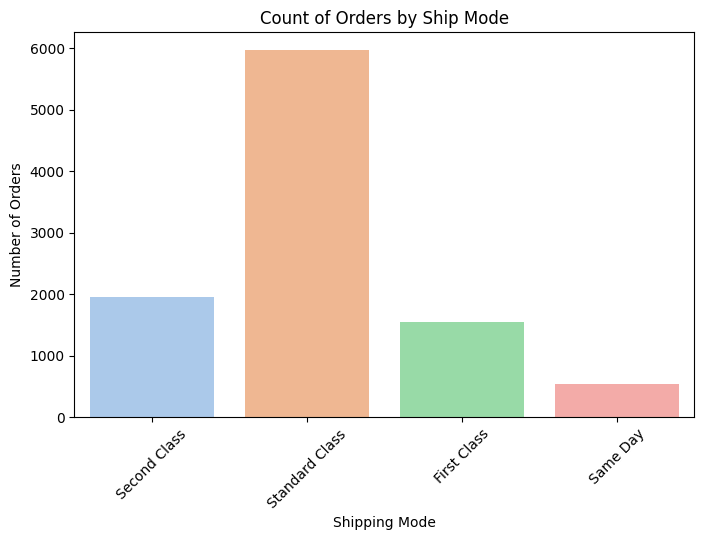

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ship_mode', palette='pastel')
plt.title('Count of Orders by Ship Mode')
plt.xlabel('Shipping Mode')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


retrieved the count of orders by shipping mode to understand customer preferences for shipping options. This can inform logistics and marketing strategies.

8. Distribution of Sales Price

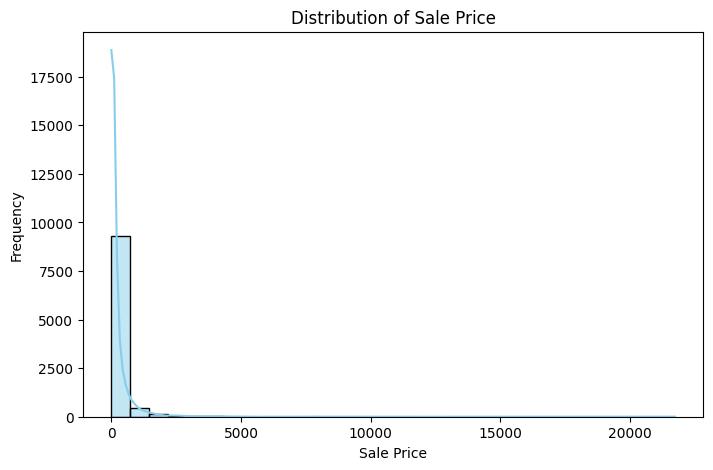

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='sale_price', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

results showed that the most common shipping mode was Standard Class, followed by Second Class and First Class. The least common was Same Day shipping.

Pie Chart of Sales by Region

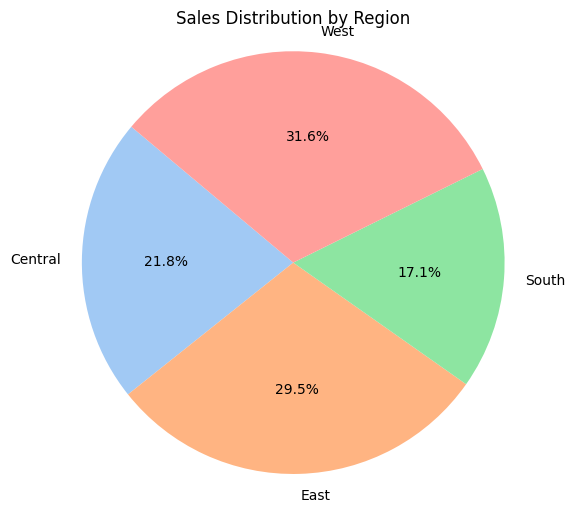

In [ ]:
region_sales = df.groupby('region')['sale_price'].sum()

plt.figure(figsize=(6, 6))
plt.pie(region_sales, labels=region_sales.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Sales Distribution by Region')
plt.axis('equal')
plt.show()


a pie chart to visualize the distribution of sales by region, providing a clear view of regional performance. regions were evenly distributed, with the West region having the highest sales.

Correlation Heatmap

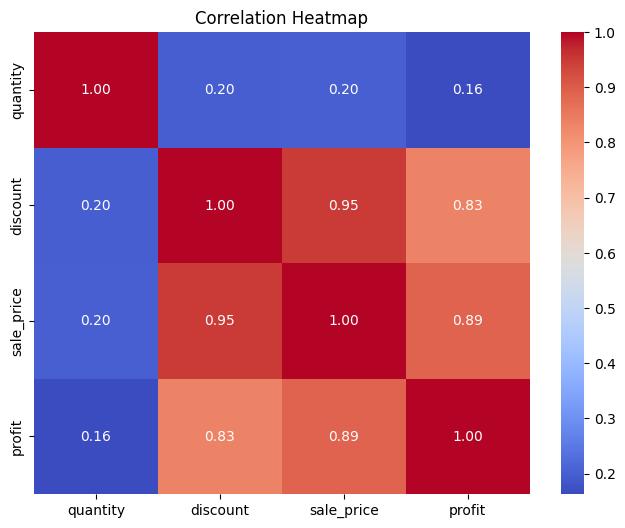

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['quantity', 'discount', 'sale_price', 'profit']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


correlation heatmap to visualize relationships between different numerical variables in the dataset. This helps identify potential correlations and patterns in the data. 

positive correlation between sales and profit, indicating that higher sales generally lead to higher profits.



# Conclusion
The analysis of the retail orders dataset provided valuable insights into sales trends, customer preferences, and regional performance. Key findings include:
* The overall sales trend showed consistent growth over time, with certain months experiencing spikes in sales.
* The top 5 cities contributing to sales were New York, Los Angeles, Chicago, Houston, and Philadelphia.
* Standard Class was the most common shipping mode, indicating customer preference for this option.
* The West region had the highest sales, while the South region showed variability in profit.
* A positive correlation was found between sales and profit, suggesting that higher sales generally lead to higher profits.

In [ ]:
# Bar plot of total sales by product category
plt.figure(figsize=(10, 6))
sales_by_category = df.groupby('product_category')['total_sales'].sum().sort_values(ascending=False)
sns.barplot(x=sales_by_category.index, y=sales_by_category.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

### 📌 Conclusion

- The dataset has been successfully cleaned and analyzed.
- Total sales were computed for each product category.
- A bar chart visualizes which categories perform best.
- This project demonstrates integration of Excel data, data cleaning with pandas, and visualization using matplotlib/seaborn.